In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy


In [2]:

# ==================== Configuration ====================
class Config:
    # Paths - Update these to match your directory structure
    TRAIN_DIR = 'Dataset/Training'  # Directory with training images
    TEST_DIR =  'Dataset/Testing'    # Directory with test images
    CHECKPOINT_DIR = 'checkpoints'
    
    # Training parameters
    IMG_SIZE = 224
    BATCH_SIZE = 24  # Optimized for RTX 2050 4GB VRAM
    NUM_EPOCHS = 60  # Increased slightly for better convergence with more freezing
    LEARNING_RATE = 0.001  # Higher LR for faster convergence
    NUM_CLASSES = 4
    
    # Validation split from training data
    VAL_RATIO = 0.15  # 15% of training data for validation
    
    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Class names
    CLASS_NAMES = ['glioma', 'meningioma', 'notumor', 'pituitary']
    
    # Early stopping
    PATIENCE = 10  # Reduced for faster training
    
    # Mixed precision training for faster training
    USE_AMP = True
    
    # Gradient accumulation for effective larger batch size
    GRAD_ACCUM_STEPS = 2  # Effective batch size = 48


In [3]:

os.makedirs(Config.CHECKPOINT_DIR, exist_ok=True)

# ==================== Custom Dataset ====================
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(Config.CLASS_NAMES)}
        
        # Load all image paths and labels
        for class_name in Config.CLASS_NAMES:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.images.append(os.path.join(class_dir, img_name))
                        self.labels.append(self.class_to_idx[class_name])
        
        print(f"Loaded {len(self.images)} images from {root_dir}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')  # Convert grayscale to RGB for pretrained models
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [4]:

# ==================== Data Transforms ====================
train_transform = transforms.Compose([
    transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [5]:

# ==================== Model Definition ====================
def create_densenet121_model(num_classes=4, pretrained=True):
    model = models.densenet121(pretrained=pretrained)
    
    # Freeze first 3 dense blocks for better accuracy and generalization
    # This preserves low and mid-level features from ImageNet
    for name, param in model.named_parameters():
        if any(x in name for x in ['conv0', 'denseblock1', 'denseblock2', 'denseblock3']):
            param.requires_grad = False
    
    # Only train denseblock4, transition layers, and classifier initially
    num_features = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(num_features, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, num_classes)
    )
    
    return model


In [6]:

# ==================== Training Function ====================
def train_epoch(model, dataloader, criterion, optimizer, device, scaler=None, scheduler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training')
    optimizer.zero_grad()
    
    for batch_idx, (inputs, labels) in enumerate(pbar):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        # Mixed precision training
        if scaler is not None and Config.USE_AMP:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss = loss / Config.GRAD_ACCUM_STEPS  # Normalize loss for gradient accumulation
            
            scaler.scale(loss).backward()
            
            # Gradient accumulation
            if (batch_idx + 1) % Config.GRAD_ACCUM_STEPS == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                if scheduler is not None:
                    scheduler.step()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss = loss / Config.GRAD_ACCUM_STEPS
            loss.backward()
            
            if (batch_idx + 1) % Config.GRAD_ACCUM_STEPS == 0:
                optimizer.step()
                optimizer.zero_grad()
                if scheduler is not None:
                    scheduler.step()
        
        running_loss += loss.item() * Config.GRAD_ACCUM_STEPS
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': loss.item() * Config.GRAD_ACCUM_STEPS, 'acc': 100 * correct / total})
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


In [7]:

# ==================== Validation Function ====================
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


In [8]:

# ==================== Test Function ====================
def test_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)


In [9]:

# ==================== Visualization Functions ====================
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(train_accs, label='Train Acc')
    ax2.plot(val_accs, label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:

# ==================== Main Training Pipeline ====================
def main():
    print(f"Using device: {Config.DEVICE}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
    
    # Load training dataset
    full_train_dataset = BrainTumorDataset(Config.TRAIN_DIR, transform=train_transform)
    
    # Split training into train and validation
    train_size = int((1 - Config.VAL_RATIO) * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size
    
    train_dataset, val_dataset = random_split(
        full_train_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    # Load test dataset
    test_dataset = BrainTumorDataset(Config.TEST_DIR, transform=val_test_transform)
    
    print(f"\nDataset splits:")
    print(f"Train: {len(train_dataset)} images")
    print(f"Val: {len(val_dataset)} images")
    print(f"Test: {len(test_dataset)} images")
    
    # Create dataloaders with Windows-compatible settings
    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, 
                             shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, 
                           shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, 
                            shuffle=False, num_workers=0, pin_memory=True)
    
    # Create model
    print("\nInitializing DenseNet121 with pretrained ImageNet weights...")
    model = create_densenet121_model(num_classes=Config.NUM_CLASSES, pretrained=True)
    model = model.to(Config.DEVICE)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Loss and optimizer - using SGD with momentum for faster convergence
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=Config.LEARNING_RATE, 
                         momentum=0.9, weight_decay=1e-4, nesterov=True)
    # OneCycleLR for fast training with high learning rates
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=Config.LEARNING_RATE,
        epochs=Config.NUM_EPOCHS,
        steps_per_epoch=len(train_loader) // Config.GRAD_ACCUM_STEPS,
        pct_start=0.3,
        anneal_strategy='cos'
    )
    
    # Mixed precision scaler
    scaler = torch.cuda.amp.GradScaler() if Config.USE_AMP else None
    
    # Training loop
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    patience_counter = 0
    
    print("\n" + "="*50)
    print("Starting Training")
    print("="*50)
    
    for epoch in range(Config.NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{Config.NUM_EPOCHS}")
        print("-" * 50)
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, Config.DEVICE, scaler, scheduler)
        val_loss, val_acc = validate(model, val_loader, criterion, Config.DEVICE)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Learning rate scheduling - step after each batch in OneCycleLR
        # No need to call scheduler.step() here as it's called in training loop
        
        # Unfreeze more layers after epoch 15 for fine-tuning
        if epoch == 15:
            print("\n Unfreezing all layers for fine-tuning...")
            for param in model.parameters():
                param.requires_grad = True
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
            }, os.path.join(Config.CHECKPOINT_DIR, 'best_model.pth'))
            print(f"✓ Best model saved with Val Acc: {val_acc:.2f}%")
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= Config.PATIENCE:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
    
    # Load best model
    model.load_state_dict(best_model_wts)
    
    # Plot training history
    plot_training_history(train_losses, val_losses, train_accs, val_accs)
    
    # Test the model
    print("\n" + "="*50)
    print("Testing Best Model")
    print("="*50)
    
    test_preds, test_labels = test_model(model, test_loader, Config.DEVICE)
    test_acc = 100 * np.sum(test_preds == test_labels) / len(test_labels)
    
    print(f"\nTest Accuracy: {test_acc:.2f}%")
    print("\nClassification Report:")
    print(classification_report(test_labels, test_preds, 
                               target_names=Config.CLASS_NAMES, digits=4))
    
    # Plot confusion matrix
    plot_confusion_matrix(test_labels, test_preds, Config.CLASS_NAMES)
    
    # Per-class accuracy
    print("\nPer-Class Accuracy:")
    cm = confusion_matrix(test_labels, test_preds)
    for i, class_name in enumerate(Config.CLASS_NAMES):
        class_acc = 100 * cm[i, i] / cm[i].sum()
        print(f"{class_name}: {class_acc:.2f}%")
    
    print("\n" + "="*50)
    print("Training Complete!")
    print("="*50)
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Model saved at: {os.path.join(Config.CHECKPOINT_DIR, 'best_model.pth')}")


Using device: cuda
CUDA available: True
GPU: NVIDIA GeForce RTX 2050
Loaded 5712 images from Dataset/Training
Loaded 1311 images from Dataset/Testing

Dataset splits:
Train: 4855 images
Val: 857 images
Test: 1311 images

Initializing DenseNet121 with pretrained ImageNet weights...


c:\Users\Anmol\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Anmol\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Anmol\AppData\Local\Temp\ipykernel_24756\922186460.py:62: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if Config.USE_AMP else None


Total parameters: 7,217,284
Trainable parameters: 3,115,396

Starting Training

Epoch 1/60
--------------------------------------------------


Training:   0%|          | 0/203 [00:00<?, ?it/s]C:\Users\Anmol\AppData\Local\Temp\ipykernel_24756\2990299890.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s]


Train Loss: 1.3818 | Train Acc: 31.70%
Val Loss: 1.3162 | Val Acc: 43.87%
Learning Rate: 0.000047
✓ Best model saved with Val Acc: 43.87%

Epoch 2/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Train Loss: 1.3047 | Train Acc: 42.00%
Val Loss: 1.2130 | Val Acc: 62.43%
Learning Rate: 0.000069
✓ Best model saved with Val Acc: 62.43%

Epoch 3/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:09<00:00,  3.80it/s]


Train Loss: 1.1989 | Train Acc: 53.57%
Val Loss: 1.0543 | Val Acc: 79.81%
Learning Rate: 0.000104
✓ Best model saved with Val Acc: 79.81%

Epoch 4/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Train Loss: 1.0234 | Train Acc: 66.82%
Val Loss: 0.8040 | Val Acc: 84.01%
Learning Rate: 0.000152
✓ Best model saved with Val Acc: 84.01%

Epoch 5/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Train Loss: 0.7959 | Train Acc: 74.42%
Val Loss: 0.5584 | Val Acc: 85.76%
Learning Rate: 0.000212
✓ Best model saved with Val Acc: 85.76%

Epoch 6/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:09<00:00,  3.82it/s]


Train Loss: 0.5940 | Train Acc: 80.93%
Val Loss: 0.4006 | Val Acc: 87.63%
Learning Rate: 0.000280
✓ Best model saved with Val Acc: 87.63%

Epoch 7/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:10<00:00,  3.27it/s]


Train Loss: 0.4750 | Train Acc: 83.67%
Val Loss: 0.3072 | Val Acc: 89.50%
Learning Rate: 0.000356
✓ Best model saved with Val Acc: 89.50%

Epoch 8/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:15<00:00,  2.31it/s]


Train Loss: 0.3923 | Train Acc: 86.51%
Val Loss: 0.2702 | Val Acc: 89.26%
Learning Rate: 0.000437

Epoch 9/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.12it/s]


Train Loss: 0.3560 | Train Acc: 87.15%
Val Loss: 0.2228 | Val Acc: 91.02%
Learning Rate: 0.000520
✓ Best model saved with Val Acc: 91.02%

Epoch 10/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.16it/s]


Train Loss: 0.3094 | Train Acc: 89.21%
Val Loss: 0.2028 | Val Acc: 91.95%
Learning Rate: 0.000604
✓ Best model saved with Val Acc: 91.95%

Epoch 11/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.14it/s]


Train Loss: 0.2828 | Train Acc: 89.91%
Val Loss: 0.1703 | Val Acc: 93.47%
Learning Rate: 0.000685
✓ Best model saved with Val Acc: 93.47%

Epoch 12/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Train Loss: 0.2521 | Train Acc: 90.94%
Val Loss: 0.1594 | Val Acc: 93.82%
Learning Rate: 0.000760
✓ Best model saved with Val Acc: 93.82%

Epoch 13/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:10<00:00,  3.43it/s]


Train Loss: 0.2301 | Train Acc: 91.78%
Val Loss: 0.1557 | Val Acc: 94.17%
Learning Rate: 0.000829
✓ Best model saved with Val Acc: 94.17%

Epoch 14/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Train Loss: 0.2277 | Train Acc: 91.84%
Val Loss: 0.1464 | Val Acc: 94.17%
Learning Rate: 0.000888

Epoch 15/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:27<00:00,  1.32it/s]


Train Loss: 0.1914 | Train Acc: 93.37%
Val Loss: 0.1287 | Val Acc: 95.10%
Learning Rate: 0.000936
✓ Best model saved with Val Acc: 95.10%

Epoch 16/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Train Loss: 0.1637 | Train Acc: 94.03%
Val Loss: 0.1145 | Val Acc: 95.45%
Learning Rate: 0.000971

🔓 Unfreezing all layers for fine-tuning...
✓ Best model saved with Val Acc: 95.45%

Epoch 17/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Train Loss: 0.1635 | Train Acc: 94.05%
Val Loss: 0.1117 | Val Acc: 95.45%
Learning Rate: 0.000993

Epoch 18/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.11it/s]


Train Loss: 0.1260 | Train Acc: 95.63%
Val Loss: 0.0827 | Val Acc: 96.85%
Learning Rate: 0.001000
✓ Best model saved with Val Acc: 96.85%

Epoch 19/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.10it/s]


Train Loss: 0.1004 | Train Acc: 96.54%
Val Loss: 0.0599 | Val Acc: 97.55%
Learning Rate: 0.000999
✓ Best model saved with Val Acc: 97.55%

Epoch 20/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:47<00:00,  1.31s/it]


Train Loss: 0.0902 | Train Acc: 96.91%
Val Loss: 0.0709 | Val Acc: 97.55%
Learning Rate: 0.000994

Epoch 21/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:44<00:00,  1.23s/it]


Train Loss: 0.0659 | Train Acc: 97.84%
Val Loss: 0.0661 | Val Acc: 97.90%
Learning Rate: 0.000987
✓ Best model saved with Val Acc: 97.90%

Epoch 22/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.06it/s]


Train Loss: 0.0701 | Train Acc: 97.71%
Val Loss: 0.0665 | Val Acc: 97.78%
Learning Rate: 0.000978

Epoch 23/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Train Loss: 0.0600 | Train Acc: 97.88%
Val Loss: 0.0687 | Val Acc: 97.67%
Learning Rate: 0.000965

Epoch 24/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Train Loss: 0.0515 | Train Acc: 98.41%
Val Loss: 0.0734 | Val Acc: 97.43%
Learning Rate: 0.000950

Epoch 25/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.23it/s]


Train Loss: 0.0522 | Train Acc: 98.23%
Val Loss: 0.0611 | Val Acc: 98.37%
Learning Rate: 0.000933
✓ Best model saved with Val Acc: 98.37%

Epoch 26/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.14it/s]


Train Loss: 0.0452 | Train Acc: 98.56%
Val Loss: 0.0553 | Val Acc: 98.13%
Learning Rate: 0.000913

Epoch 27/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.22it/s]


Train Loss: 0.0363 | Train Acc: 98.91%
Val Loss: 0.0637 | Val Acc: 98.02%
Learning Rate: 0.000891

Epoch 28/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.19it/s]


Train Loss: 0.0355 | Train Acc: 98.95%
Val Loss: 0.0522 | Val Acc: 98.37%
Learning Rate: 0.000866

Epoch 29/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.09it/s]


Train Loss: 0.0279 | Train Acc: 99.22%
Val Loss: 0.0509 | Val Acc: 98.13%
Learning Rate: 0.000840

Epoch 30/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.10it/s]


Train Loss: 0.0322 | Train Acc: 98.99%
Val Loss: 0.0665 | Val Acc: 98.02%
Learning Rate: 0.000811

Epoch 31/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.14it/s]


Train Loss: 0.0220 | Train Acc: 99.16%
Val Loss: 0.0568 | Val Acc: 97.90%
Learning Rate: 0.000781

Epoch 32/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.11it/s]


Train Loss: 0.0244 | Train Acc: 99.24%
Val Loss: 0.0597 | Val Acc: 98.13%
Learning Rate: 0.000750

Epoch 33/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.07it/s]


Train Loss: 0.0274 | Train Acc: 99.26%
Val Loss: 0.0774 | Val Acc: 97.90%
Learning Rate: 0.000717

Epoch 34/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.10it/s]


Train Loss: 0.0241 | Train Acc: 99.32%
Val Loss: 0.0442 | Val Acc: 98.25%
Learning Rate: 0.000682

Epoch 35/60
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.13it/s]


Train Loss: 0.0208 | Train Acc: 99.46%
Val Loss: 0.0627 | Val Acc: 98.37%
Learning Rate: 0.000647

Early stopping triggered after 35 epochs


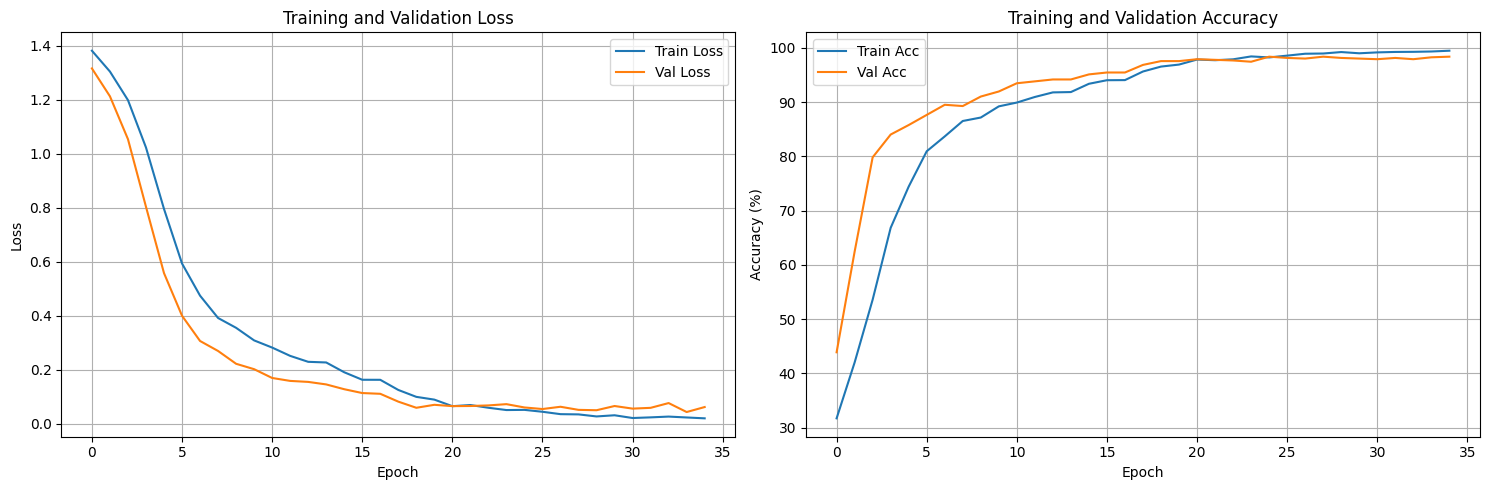


Testing Best Model


Testing: 100%|██████████| 55/55 [00:21<00:00,  2.56it/s]



Test Accuracy: 98.40%

Classification Report:
              precision    recall  f1-score   support

      glioma     0.9966    0.9633    0.9797       300
  meningioma     0.9645    0.9771    0.9708       306
     notumor     0.9806    0.9975    0.9890       405
   pituitary     0.9967    0.9933    0.9950       300

    accuracy                         0.9840      1311
   macro avg     0.9846    0.9828    0.9836      1311
weighted avg     0.9842    0.9840    0.9840      1311



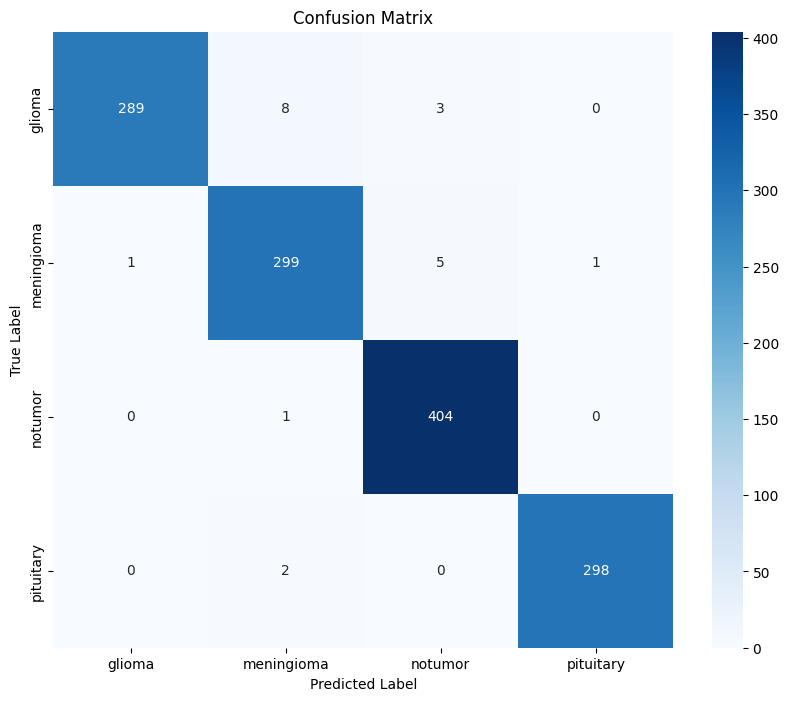


Per-Class Accuracy:
glioma: 96.33%
meningioma: 97.71%
notumor: 99.75%
pituitary: 99.33%

Training Complete!
Best Validation Accuracy: 98.37%
Test Accuracy: 98.40%
Model saved at: checkpoints\best_model.pth


In [11]:

if __name__ == "__main__":
    main()